In [8]:
# Standard library
import os
import struct
import time
import random
import argparse
import sys

# Third-party library
import numpy as np
from math import e
from typing import List
import math
import matplotlib.pyplot as plt

# Pytorch
import torch
from torch import nn
import torch.nn.functional as F

# Tools
from einops.layers.torch import Rearrange, Reduce
from einops import rearrange

import lightning as L

# Files
sys.path.append(os.path.abspath("../models"))
from res_cnn_64to1024 import VRES_CNN_64to1024
from lightning_caller import Resolution_Recovery

sys.path.append(os.path.abspath("../utils"))
from paired_dataloader import Data
from evaluation import eval_reconstruction, loss_visualization

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DATASET_DIR = "../dataset/raw"

# DRAFT

In [9]:
data_module = Data(
    root_dir=DATASET_DIR,
    brightness=1.0,
    batch_size=32,
    resolution_lr=64,
    resolution_hr=1024
)

data_module.setup()

train_loader  = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

In [10]:
lr_batch, hr_batch = next(iter(data_module.train_dataloader()))
print(lr_batch.shape, hr_batch.shape)

torch.Size([32, 1, 64, 64]) torch.Size([32, 1, 1024, 1024])


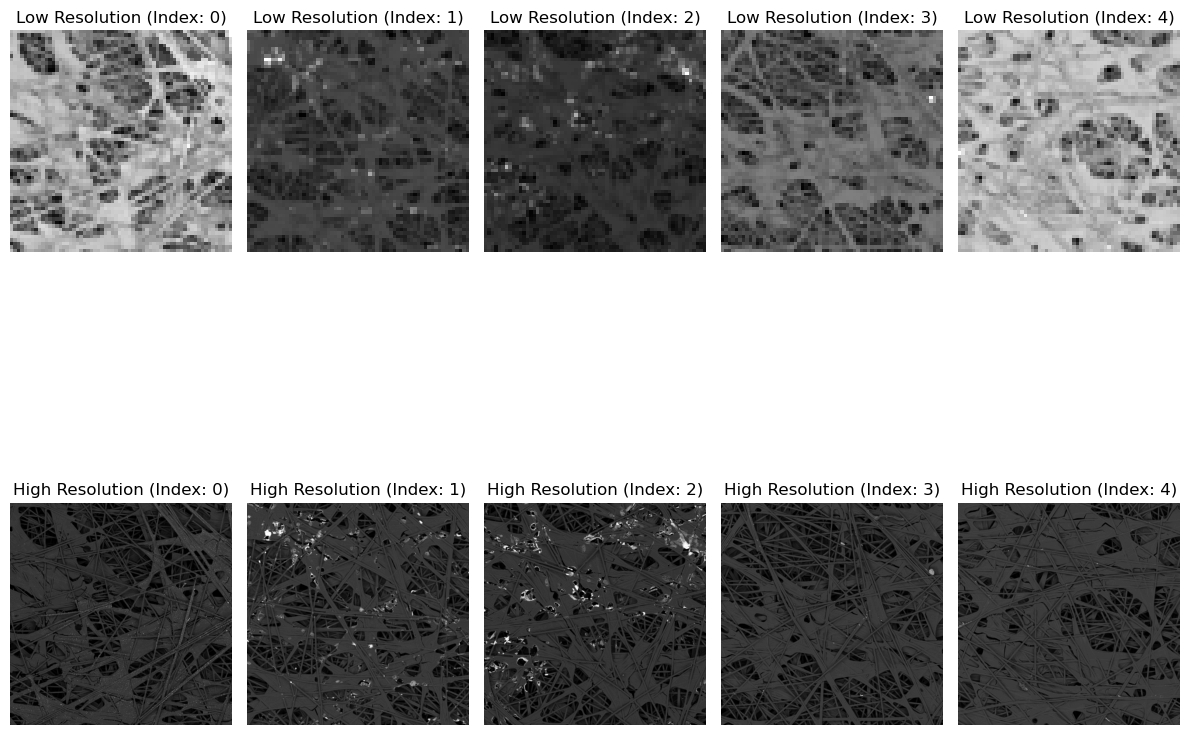

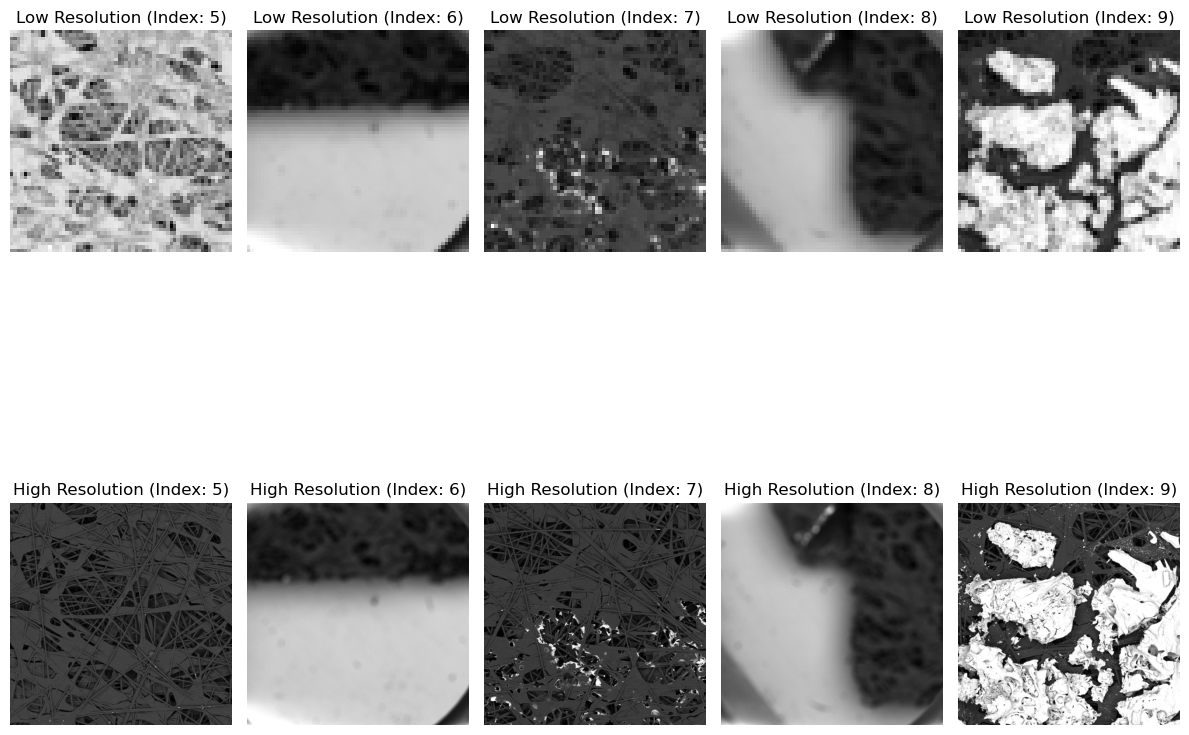

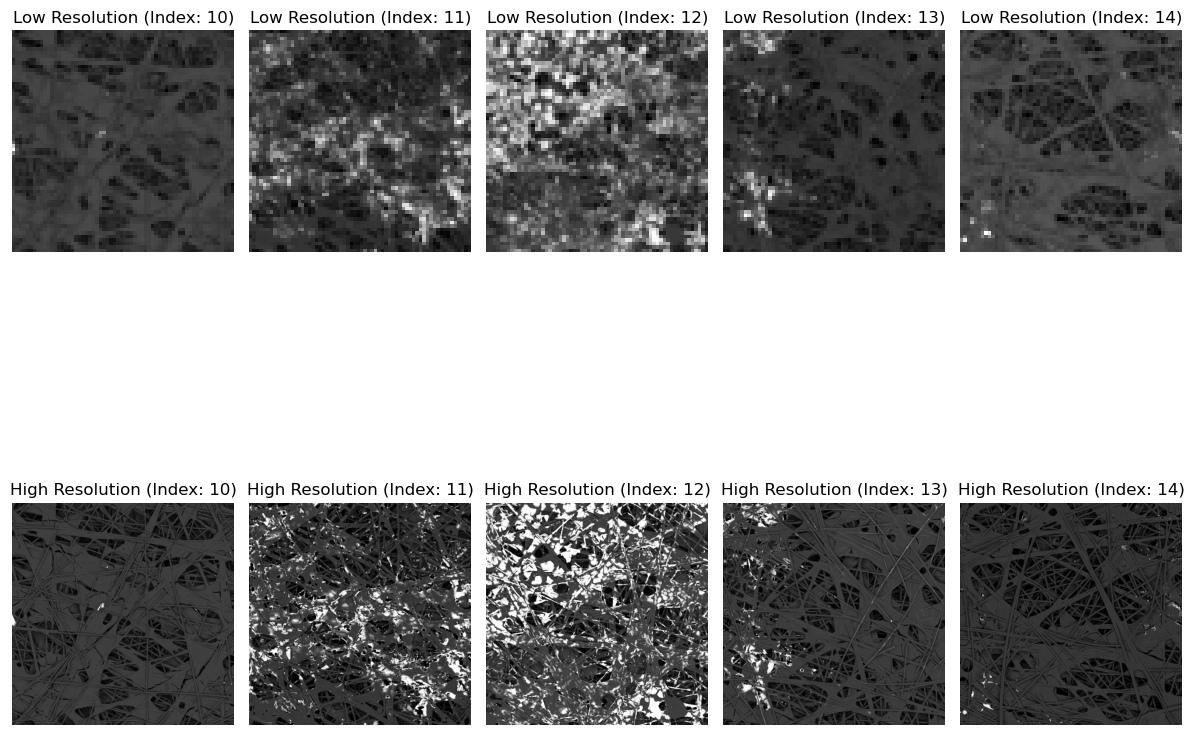

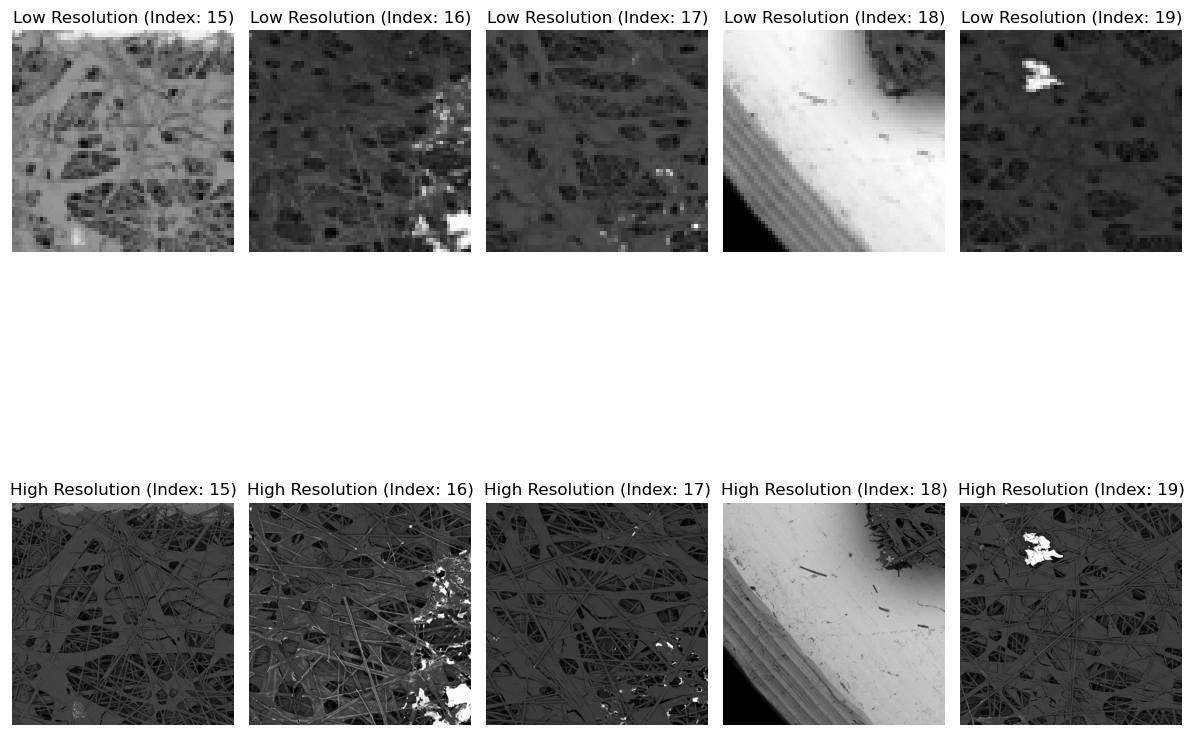

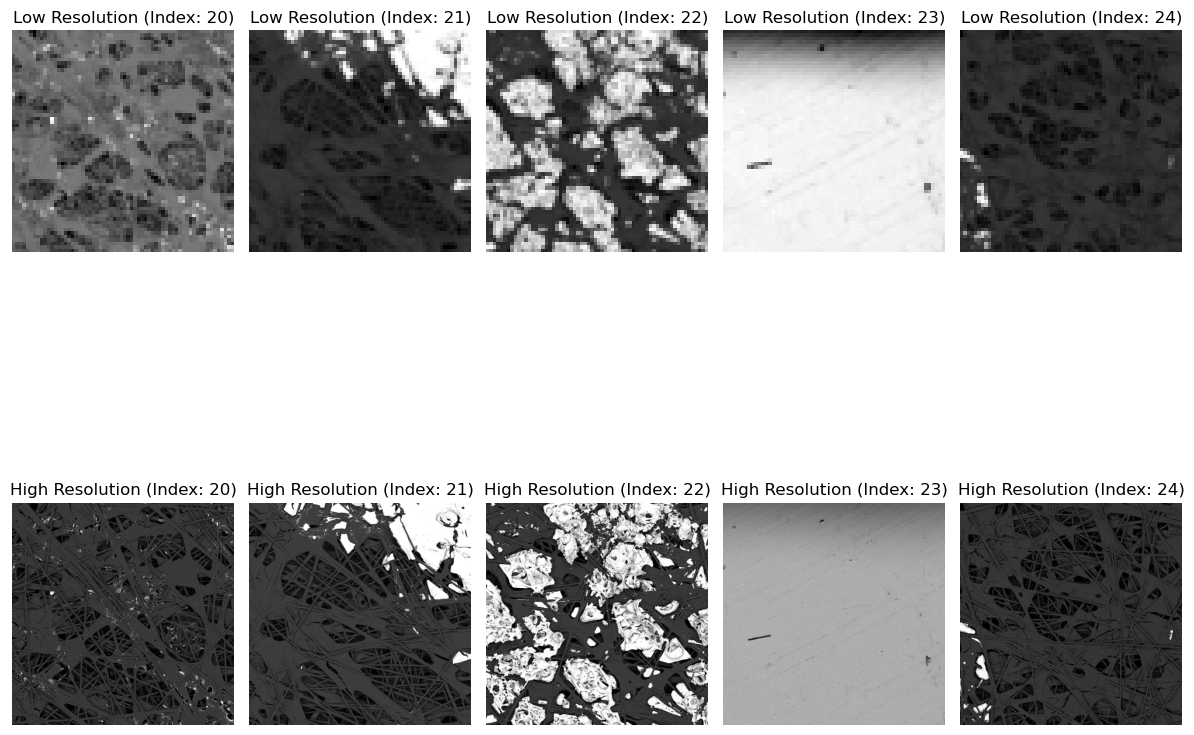

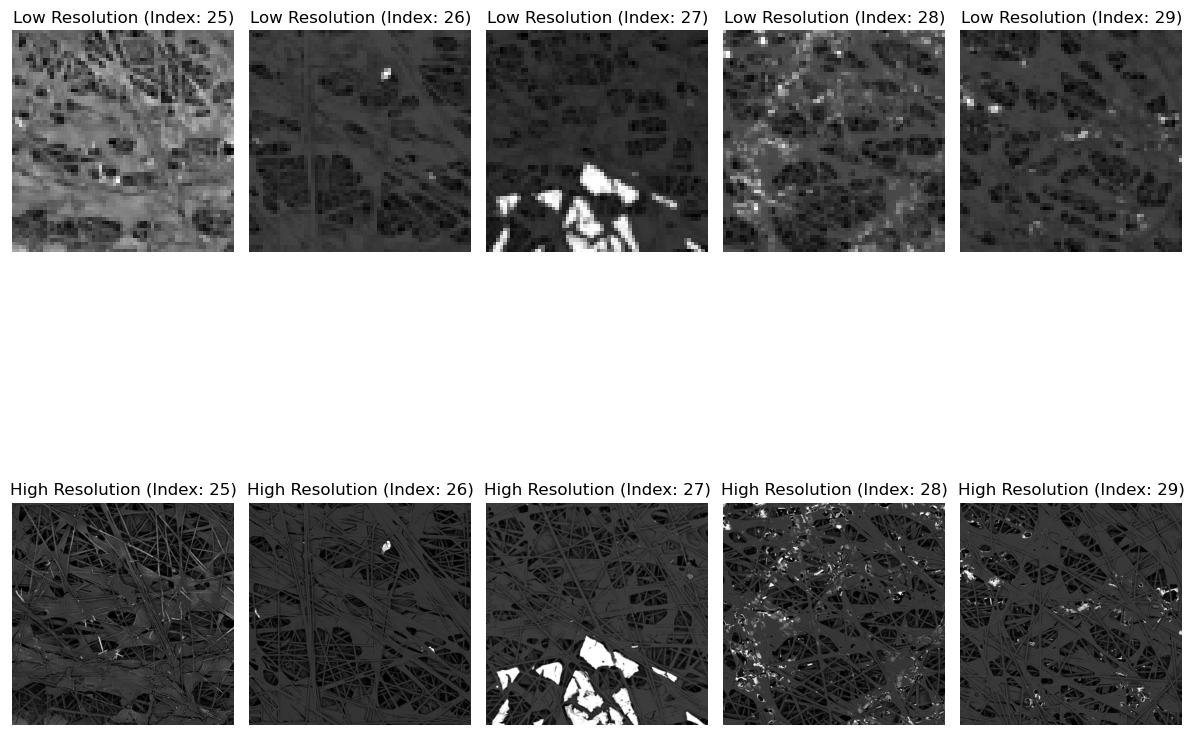

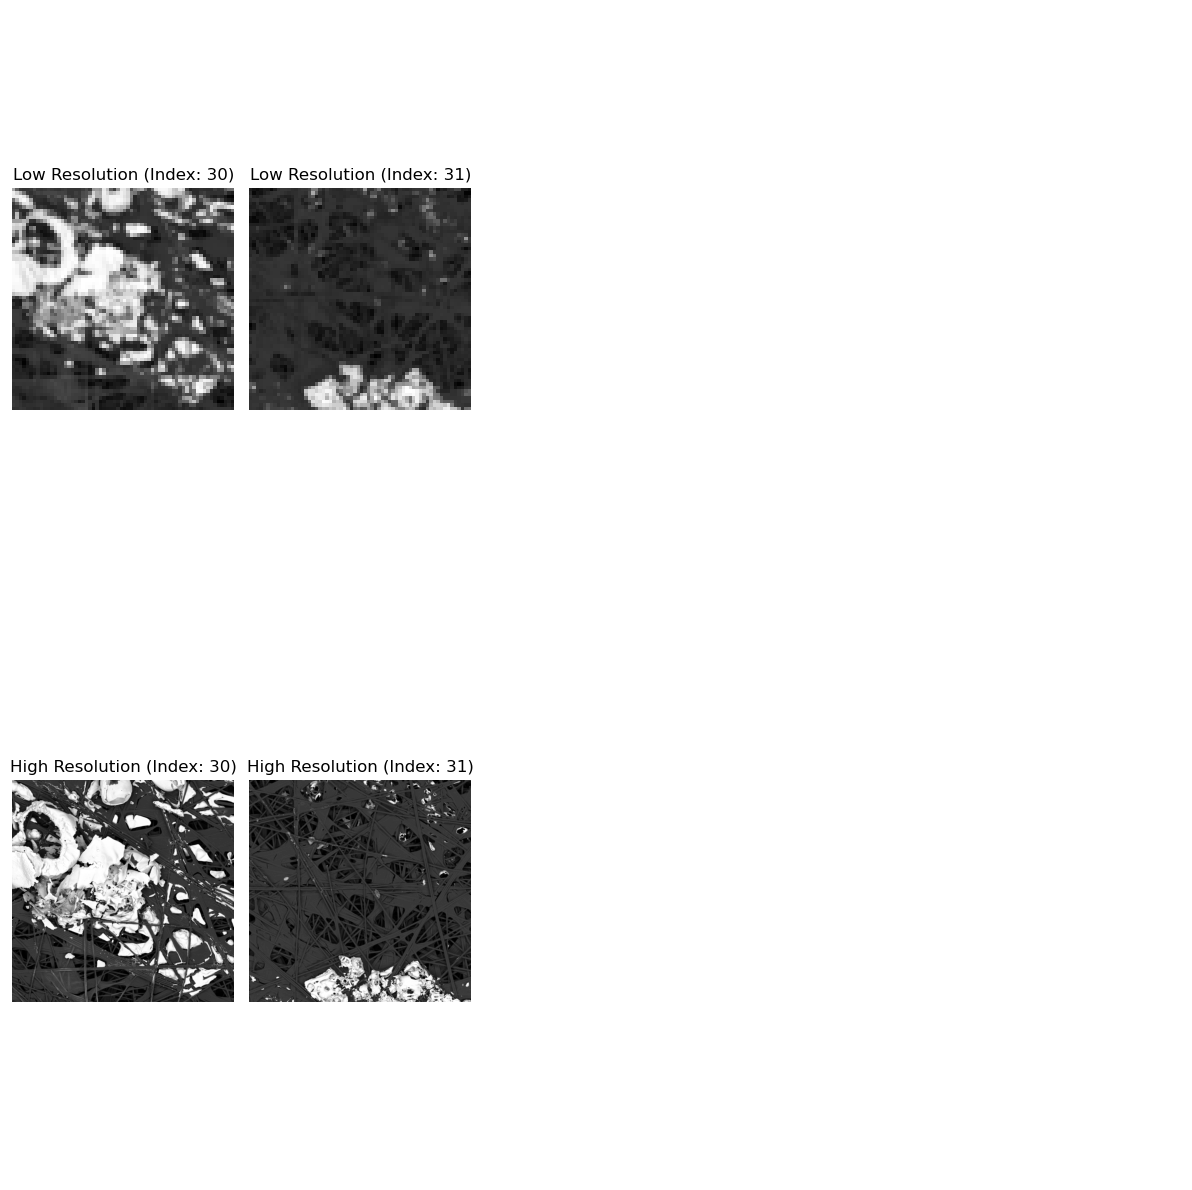

In [11]:
batch_size = lr_batch.shape[0]
pairs_per_row = 5
rows = (batch_size + pairs_per_row - 1) // pairs_per_row

for row in range(rows):
    fig, axs = plt.subplots(2, pairs_per_row, figsize=(12, 12))
    for col in range(pairs_per_row):
        idx = row * pairs_per_row + col
        if idx >= batch_size:
            axs[0, col].axis("off")
            axs[1, col].axis("off")
            continue

        lr_img = lr_batch[idx].squeeze().numpy()
        hr_img = hr_batch[idx].squeeze().numpy()

        axs[0, col].imshow(lr_img, cmap='gray')
        axs[0, col].set_title(f"Low Resolution (Index: {idx})")
        axs[0, col].axis("off")

        axs[1, col].imshow(hr_img, cmap='gray')
        axs[1, col].set_title(f"High Resolution (Index: {idx})")
        axs[1, col].axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
trainer = L.Trainer(max_epochs = 50,
                   default_root_dir = "./",
                   accelerator="auto",
                   devices="auto")
trainer.fit(model_to_be_trained, train_loader, val_loader)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-01-31 09:38:37.765721: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-31 09:38:38.768776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-31 09:38:39.097045: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable t

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/gridsan/yyao/.local/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
Please check my code for potential bugs:

# Standard library
import os
import sys
import argparse
import struct
import time

# Lightning
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint

# Project files
sys.path.append(os.path.abspath("../models"))
from res_cnn_64to1024 import VRES_CNN_64to1024
from lightning_caller import Resolution_Recovery

sys.path.append(os.path.abspath("../utils"))
from paired_dataloader import Data

DATASET_DIR = "../dataset/raw"

def main(
    model_to_be_trained: L.LightningModule,
    max_epochs: int,
    ckpt_interval: int,
    ckpt_dir: str,
    num_nodes: int,
    strategy: str = "ddp"
):
    L.seed_everything(42)

    # Data initialization
    data = Data(
        root_dir=DATASET_DIR,
        brightness=1.0,
        batch_size=32,
        resolution_lr=64,
        resolution_hr=1024
    )
    data.setup()

    train_loader = data.train_dataloader()
    val_loader = data.val_dataloader()

    # Callback for checkpointing
    checkpoint_callback = ModelCheckpoint(
        dirpath=ckpt_dir,
        filename="epoch-{epoch:07d}",
        save_top_k=-1,
        every_n_epochs=ckpt_interval
    )

    # Create Trainer
    trainer = L.Trainer(
        max_epochs=max_epochs,
        callbacks=[checkpoint_callback],
        default_root_dir=ckpt_dir,
        accelerator="gpu",
        devices="auto",
        strategy=strategy,
        num_nodes=num_nodes
    )

    # Train
    trainer.fit(
        model=model_to_be_trained,
        train_dataloaders=train_loader,
        val_dataloaders=val_loader
    )

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Deep Faker Training Initiated.")
    parser.add_argument("--max_epochs", type=int, required=True,
                        help="Number of epochs to train")
    parser.add_argument("--ckpt_dir", type=str, required=True,
                        help="Directory to store checkpoints")
    parser.add_argument("--ckpt_interval", type=int, default=1000,
                        help="Save a checkpoint every N epochs")
    parser.add_argument("--ckpt_path", type=str, default=None,
                        help="Path to checkpoint for resuming")
    parser.add_argument("--strategy", type=str, default="ddp",
                        help="PyTorch Lightning training strategy")
    parser.add_argument("--num_nodes", type=int, required=True,
                        help="Number of nodes")
    args = parser.parse_args()

    if args.ckpt_path is not None:
        model_to_be_trained = Resolution_Recovery.load_from_checkpoint(
            checkpoint_path=args.ckpt_path,
            model=VRES_CNN_64to1024(input_resolution=64)
        )
    else:
        model_to_be_trained = Resolution_Recovery(
            model=VRES_CNN_64to1024(input_resolution=64)
        )

    main(
        model_to_be_trained=model_to_be_trained,
        max_epochs=args.max_epochs,
        ckpt_interval=args.ckpt_interval,
        ckpt_dir=args.ckpt_dir,
        strategy=args.strategy,
        num_nodes = args.num_nodes
    )


In [ ]:
from evaluation import eval_reconstruction, loss_visualization

In [ ]:
metrics_path_1 = "/home/gridsan/yyao/Research_Projects/Microstructure_Enough/deepfaker/demo/checkpoint_demo/res_cnn/256/brightness_1/lightning_logs/version_0/metrics.csv"
loss_visualization(start_epoch=49,epoch_interval=5000,metrics_path=metrics_path_1)